Author: Louis Owen (https://louisowen6.github.io/)

In [1]:
import pandas as pd
import numpy as np
import random
import re

import copy

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

from nltk import ngrams
import pylcs
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

# Load Data

In [2]:
df_paragraph = pd.DataFrame(columns=['category','paragraph_1','paragraph_2','len_paragraph_1','is_plagiarism','plagiarism_type','cleaned_paragraph_1','cleaned_paragraph_2'])

with open('../data/plagiarism_data_train.tsv','r') as f_in:
    for i,line in enumerate(f_in):
        if i>0:
            columns = line.split('\t')
            columns[-1] = re.sub('\n','',columns[-1])
            df_paragraph.loc[i] = columns

In [3]:
df_paragraph_test = pd.DataFrame(columns=['category','paragraph_1','paragraph_2','len_paragraph_1','is_plagiarism','plagiarism_type','cleaned_paragraph_1','cleaned_paragraph_2'])

with open('../data/plagiarism_data_test.tsv','r') as f_in:
    for i,line in enumerate(f_in):
        if i>0:
            columns = line.split('\t')
            columns[-1] = re.sub('\n','',columns[-1])
            df_paragraph_test.loc[i] = columns

In [4]:
df_paragraph = df_paragraph[['category','plagiarism_type','is_plagiarism','cleaned_paragraph_1','cleaned_paragraph_2']].reset_index(drop=True)
df_paragraph_test = df_paragraph_test[['category','plagiarism_type','is_plagiarism','cleaned_paragraph_1','cleaned_paragraph_2']].reset_index(drop=True)

In [5]:
df_paragraph

,category,plagiarism_type,is_plagiarism,cleaned_paragraph_1,cleaned_paragraph_2
0,geography,non-plagiarism,False,1950-an auguste piccard temu batiskap trieste ...,definisi bangun usaha kondisi hidup masyarakat...
1,environment,structural change,True,artikel 3 4 united nations framework conventio...,maksud artikel 3 4 united nations framework co...
2,biology,paraphrase,True,mudah tangkap bunuh berkat cepat kuat buru jar...,mudah tangkap bunuh berkat cepat kuat buru jar...
3,environment,non-plagiarism,False,as angka 17 miliar kwh 27 000 000 000 lb 1 210...,hierarki sampah - hierarki sampah rujuk 3 m sa...
4,technology,non-plagiarism,False,letak 13 2 mil 21 2 km koordinat salah operato...,e deck upper deck manfaat akomodasi kamar tidu...
...,...,...,...,...,...
2007,environment,non-plagiarism,False,pondok pesantren asrama didik islam ponpes api...,efisiensi usaha tuju butuh alat sistem hubung ...
2008,chemistry,non-plagiarism,False,hukum kekal massa laku reaksi kimia massa reak...,senyawa tunggal senyawa organik metan turun
2009,biology,non-plagiarism,False,bakteri orang kadang sulit sembuh bakteri alam...,brevicauda pisah milik musim kawin beda beda c...
2010,environment,structural change,True,diagram siklus angka warna hitam simpan reserv...,diagram siklus karbonium angka warna aswad uta...


In [6]:
df_paragraph_test

,category,plagiarism_type,is_plagiarism,cleaned_paragraph_1,cleaned_paragraph_2
0,environment,non-plagiarism,False,material sampah organik residu tanam sampah ma...,ilmuwan panas global daerah utara bahan bumi u...
1,geography,non-plagiarism,False,faktor ubah tipe tutup lahan hutan jamah miner...,spesiasi populasi tepi jangkau isolasi kembang...
2,economy,non-plagiarism,False,islam bas sektor riil lihat al-baqarah 275 dik...,tekan global covid-19 jatuh harga minyak batub...
3,covid19,structural change,True,psbb jalan daerah perintah pusat longgar strat...,psbb berangkat medan perintah pusat longgar li...
4,environment,translated,True,panas global dampak suhu takut konsisten produ...,warming up global dampak suhu so then takut le...
...,...,...,...,...,...
498,environment,paraphrase,True,bentuk biomassa padat cair gas metode produksi...,bentuk biomassa padat cair gas metode produksi...
499,environment,structural change,True,konservasi tantang bijak program kembang tekno...,lestari tantang nan harap arif cadang ekspansi...
500,technology,non-plagiarism,False,garis ai paham pikir ai konvensional cerdas ko...,akurat metode cepat
501,biology,non-plagiarism,False,antibiotik spesifik proses bakteri mutasi bakt...,teori evolusi homologi struktur hewan milik ne...


# Feature Engineering

In [7]:
def extract_ngram_similarity(sentence_1,sentence_2,n=4):
    ngrams_set_1 = set()
    ngrams_set_2 = set()
    
    ngram1 = ngrams(sentence_1.split(), n)
    for grams in ngram1:
        ngrams_set_1.add(grams)
        
    ngram2 = ngrams(sentence_2.split(), n)
    for grams in ngram2:
        ngrams_set_2.add(grams)
    
    try:
        jaccard_sim = len(ngrams_set_1.intersection(ngrams_set_2)) / len(ngrams_set_1.union(ngrams_set_2))

        return jaccard_sim
    except:
        return 0

In [8]:
def feature_engineering(df_train,df_test):
    corpus = df_train['cleaned_paragraph_1'].to_list() + df_train['cleaned_paragraph_2'].to_list()
    
    # Word Pairs
    bigram_vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2), min_df=0.002)
    bigram_vectorizer.fit(corpus)
    
    transformed_array_train = bigram_vectorizer.transform(df_train['cleaned_paragraph_1'] + ' '+ df_train['cleaned_paragraph_2']).toarray()
    transformed_array_test = bigram_vectorizer.transform(df_test['cleaned_paragraph_1'] + ' '+ df_test['cleaned_paragraph_2']).toarray()
    num_feats = transformed_array_train.shape[1]

    df_preprocessed = pd.DataFrame(transformed_array_train,columns=[f'word_pairs_{i}' for i in range(num_feats)])
    df_preprocessed_test = pd.DataFrame(transformed_array_test,columns=[f'word_pairs_{i}' for i in range(num_feats)])
    
    # Words Similarity
    df_preprocessed['words_similarity'] = df_train.apply(lambda x: extract_ngram_similarity(x['cleaned_paragraph_1'],x['cleaned_paragraph_2'],n=1), axis=1)
    df_preprocessed_test['words_similarity'] = df_test.apply(lambda x: extract_ngram_similarity(x['cleaned_paragraph_1'],x['cleaned_paragraph_2'],n=1), axis=1)
    
    # Fingerprints Similarity
    df_preprocessed['fingerprint_similarity'] = df_train.apply(lambda x: extract_ngram_similarity(x['cleaned_paragraph_1'],x['cleaned_paragraph_2'],n=4), axis=1)
    df_preprocessed_test['fingerprint_similarity'] = df_test.apply(lambda x: extract_ngram_similarity(x['cleaned_paragraph_1'],x['cleaned_paragraph_2'],n=4), axis=1)
    
    # Longest Common Subsequence
    df_preprocessed['lcs'] = df_train.apply(lambda x: pylcs.lcs2(x['cleaned_paragraph_1'],x['cleaned_paragraph_2'])/max(len(x['cleaned_paragraph_1']),len(x['cleaned_paragraph_2'])), axis=1)
    df_preprocessed_test['lcs'] = df_test.apply(lambda x: pylcs.lcs2(x['cleaned_paragraph_1'],x['cleaned_paragraph_2'])/max(len(x['cleaned_paragraph_1']),len(x['cleaned_paragraph_2'])), axis=1)
    
    # LSA Similarity
    num_component = 200
    tfidf_vectorizer = TfidfVectorizer(use_idf=True,smooth_idf=True)
    lsa = TruncatedSVD(num_component, algorithm = 'randomized',random_state=0)

    tfidf_vectorizer.fit(corpus)
    dtm = tfidf_vectorizer.transform(corpus)
    lsa.fit(dtm)
    
    dtm_lsa_train_1 = lsa.transform(tfidf_vectorizer.transform(df_train['cleaned_paragraph_1'].to_list()))
    dtm_lsa_train_2 = lsa.transform(tfidf_vectorizer.transform(df_train['cleaned_paragraph_2'].to_list()))
    
    cosine_sim_train = []
    for i in range(dtm_lsa_train_1.shape[0]):
        cosine_sim_train.append(cosine_similarity([dtm_lsa_train_1[i]],[dtm_lsa_train_2[i]])[0][0])
    
    dtm_lsa_test_1 = lsa.transform(tfidf_vectorizer.transform(df_test['cleaned_paragraph_1'].to_list()))
    dtm_lsa_test_2 = lsa.transform(tfidf_vectorizer.transform(df_test['cleaned_paragraph_2'].to_list()))
    
    cosine_sim_test = []
    for i in range(dtm_lsa_test_1.shape[0]):
        cosine_sim_test.append(cosine_similarity([dtm_lsa_test_1[i]],[dtm_lsa_test_2[i]])[0][0])
    
    df_preprocessed['lsa_similarity'] = cosine_sim_train
    df_preprocessed_test['lsa_similarity'] = cosine_sim_test
    
    # Add Target Variables
    df_preprocessed[['category','plagiarism_type','is_plagiarism']] = df_train[['category','plagiarism_type','is_plagiarism']]
    df_preprocessed_test[['category','plagiarism_type','is_plagiarism']] = df_test[['category','plagiarism_type','is_plagiarism']]
    
    return df_preprocessed,df_preprocessed_test

In [9]:
df_preprocessed,df_preprocessed_test = feature_engineering(df_paragraph,df_paragraph_test)

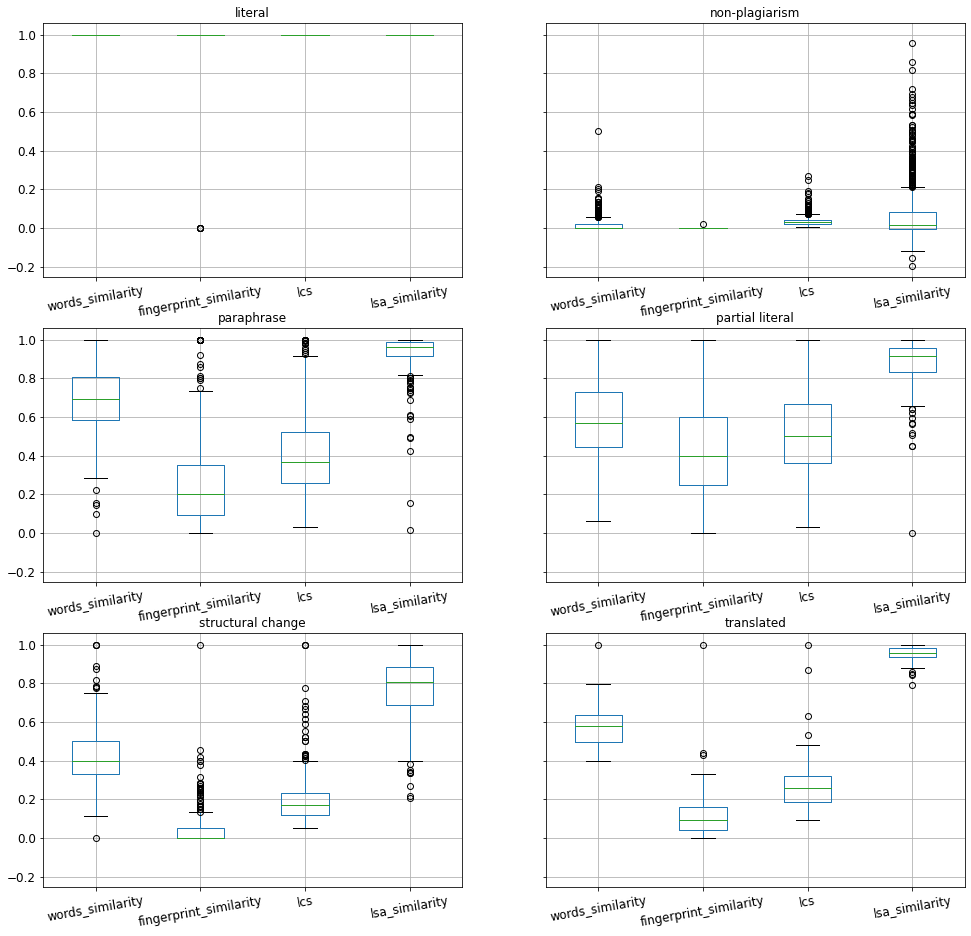

In [10]:
df_preprocessed[[x for x in df_preprocessed.columns if 'word_pairs' not in x]].groupby('plagiarism_type').boxplot(rot=10, fontsize=12, figsize=(16,16))
plt.show()

# Cross-Validation

In [23]:
def run_pipeline(df_paragraph_train,df_paragraph_val,model,use_scaler,return_model=False,inference_mode=False):
    model_temp = copy.deepcopy(model)
    
    df_preprocessed_train,df_preprocessed_val = feature_engineering(df_paragraph_train,df_paragraph_val)
    X_train = df_preprocessed_train.drop(columns=['category','plagiarism_type','is_plagiarism'])
    y_train = df_preprocessed_train['is_plagiarism'].apply(lambda x: 1 if x=='True' else 0)

    if use_scaler:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)

    X_val = df_preprocessed_val.drop(columns=['category','plagiarism_type','is_plagiarism'])
    y_val = df_preprocessed_val['is_plagiarism'].apply(lambda x: 1 if x=='True' else 0)

    if use_scaler:
        X_val = scaler.transform(X_val)
    
    if not inference_mode:
        model_temp.fit(X_train, y_train)

    y_pred = model_temp.predict(X_val)
    
    if return_model:
        return y_val,y_pred,model_temp
    else:
        return y_val,y_pred

In [12]:
def cross_val_pipeline(df_paragraph,model,metric='accuracy',use_scaler=False):
    metrics_list = []

    kf = KFold(n_splits=7,shuffle=True,random_state=0)
    for train_index, val_index in kf.split(df_paragraph):
        df_paragraph_train = df_paragraph.loc[train_index].reset_index(drop=True)
        df_paragraph_val = df_paragraph.loc[val_index].reset_index(drop=True)
        
        y_val,y_pred = run_pipeline(df_paragraph_train,df_paragraph_val,model,use_scaler)

        print(classification_report(y_val, y_pred))

        metrics_list.append(classification_report(y_val, y_pred,output_dict=True)[metric])
        
    return metrics_list

## Naive Bayes

In [13]:
from sklearn.naive_bayes import GaussianNB

In [14]:
acc_list = cross_val_pipeline(df_paragraph,GaussianNB(),metric='accuracy',use_scaler=False)

              precision    recall  f1-score   support

           0       0.97      0.67      0.80       144
           1       0.75      0.98      0.85       144

    accuracy                           0.83       288
   macro avg       0.86      0.83      0.82       288
weighted avg       0.86      0.83      0.82       288

              precision    recall  f1-score   support

           0       0.97      0.68      0.80       165
           1       0.69      0.98      0.81       123

    accuracy                           0.81       288
   macro avg       0.83      0.83      0.81       288
weighted avg       0.85      0.81      0.80       288

              precision    recall  f1-score   support

           0       0.97      0.72      0.82       130
           1       0.81      0.98      0.89       158

    accuracy                           0.86       288
   macro avg       0.89      0.85      0.85       288
weighted avg       0.88      0.86      0.86       288

              preci

In [15]:
print(f'Accuracy | Avg: {round(np.mean(acc_list),5)}, Std. {round(np.std(acc_list),5)}')

Accuracy | Avg: 0.79816, Std. 0.08821


## SVM

In [16]:
from sklearn.svm import SVC

In [17]:
acc_list = cross_val_pipeline(df_paragraph,SVC(gamma='auto',kernel='linear'),metric='accuracy',use_scaler=False)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       144
           1       0.99      0.99      0.99       144

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       165
           1       0.98      0.98      0.98       123

    accuracy                           0.98       288
   macro avg       0.98      0.98      0.98       288
weighted avg       0.98      0.98      0.98       288

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       130
           1       0.98      0.98      0.98       158

    accuracy                           0.98       288
   macro avg       0.98      0.98      0.98       288
weighted avg       0.98      0.98      0.98       288

              preci

In [18]:
print(f'Accuracy | Avg: {round(np.mean(acc_list),5)}, Std. {round(np.std(acc_list),5)}')

Accuracy | Avg: 0.9831, Std. 0.00507


## Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
acc_list = cross_val_pipeline(df_paragraph,RandomForestClassifier(random_state=0,n_estimators=100),metric='accuracy',use_scaler=False)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       144
           1       1.00      0.99      0.99       144

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       165
           1       0.98      0.98      0.98       123

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       130
           1       0.99      0.99      0.99       158

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288

              preci

In [21]:
print(f'Accuracy | Avg: {round(np.mean(acc_list),5)}, Std. {round(np.std(acc_list),5)}')

Accuracy | Avg: 0.98956, Std. 0.00186


## XGBoost

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [23]:
acc_list = cross_val_pipeline(df_paragraph,GradientBoostingClassifier(random_state=0,n_estimators=100,learning_rate=0.15),metric='accuracy',use_scaler=False)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       144
           1       1.00      0.99      0.99       144

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       165
           1       0.98      0.98      0.98       123

    accuracy                           0.98       288
   macro avg       0.98      0.98      0.98       288
weighted avg       0.98      0.98      0.98       288

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       130
           1       0.99      0.99      0.99       158

    accuracy                           0.99       288
   macro avg       0.99      0.99      0.99       288
weighted avg       0.99      0.99      0.99       288

              preci

In [24]:
print(f'Accuracy | Avg: {round(np.mean(acc_list),5)}, Std. {round(np.std(acc_list),5)}')

Accuracy | Avg: 0.98707, Std. 0.00445


# Hold-Out Prediction

In [15]:
from sklearn.ensemble import RandomForestClassifier

In [16]:
y_test,y_pred,fitted_model = run_pipeline(df_paragraph,df_paragraph_test,
                                         RandomForestClassifier(random_state=0,n_estimators=100),
                                         use_scaler=False,return_model=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       252
           1       0.98      0.99      0.98       251

    accuracy                           0.98       503
   macro avg       0.98      0.98      0.98       503
weighted avg       0.98      0.98      0.98       503



In [17]:
classification_report(y_test, y_pred,output_dict=True)['accuracy']

0.9840954274353877

In [18]:
classification_report(y_test, y_pred,output_dict=True)['macro avg']['f1-score']

0.9840948616600791

In [20]:
import pickle

In [19]:
fitted_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [21]:
pickle.dump(fitted_model, open('../model/classic_ml_model.pkl', 'wb'))

In [22]:
loaded_model = pickle.load(open('../model/classic_ml_model.pkl', 'rb'))

In [25]:
y_test,y_pred = run_pipeline(df_paragraph,df_paragraph_test,
                             loaded_model,
                             use_scaler=False,return_model=False,inference_mode=True)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       252
           1       0.98      0.99      0.98       251

    accuracy                           0.98       503
   macro avg       0.98      0.98      0.98       503
weighted avg       0.98      0.98      0.98       503

